# RNN을 이용한 텍스트 분류(Text Classification)

<br>

## 케라스를 이용한 텍스트 분류 개요

![분류[1].png](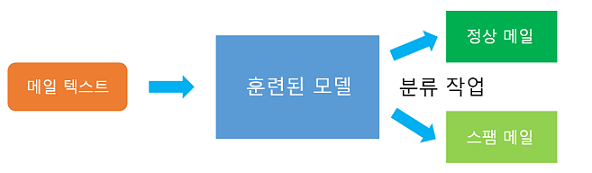)

<br>

### RNN의 다-대-일(Many-to-One) 문제

![many_to_one[1].PNG](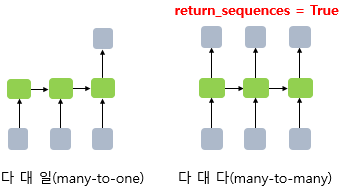)


- 텍스트 분류는 모든 시점(time step)에 대해서 입력을 받지만 최종 시점의 RNN 셀만이 은닉 상태를 출력하고, 이것이 출력층으로 가서 활성화 함수를 통해 정답을 고르는 문제

  - 이때 두 개의 선택지 중에서 정답를 고르는 이진 분류(Binary Classification) 문제
    - **이진 분류의 문제의 경우 출력층의 활성화 함수로 시그모이드 함수를, 손실 함수로 `binary_crossentropy`를 사용**
  - 세 개 이상의 선택지 중에서 정답을 고르는 다중 클래스 분류(Multi-Class Classification) 문제
    - **다중 클래스 문제라면 출력층의 활성화 함수로 소프트맥스 함수를, 손실 함수로 `categorical_crossentropy`를 사용**
    - **다중 클래스 분류 문제의 경우에는 클래스가 N개라면 출력층에 해당되는 밀집층(dense layer)의 크기는 N**
      
      (출력층 뉴런의 수는 N개)


<br>

## 스팸 메일 분류

<br>

#### 데이터 로드 전처리

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [5]:
data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data.head(5)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


<br>

- v2 열에서 중복인 내용이 있다면 중복 제거

In [8]:
data.drop_duplicates(subset=['v2'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5169


<br>

- 레이블 값의 분포를 시각화

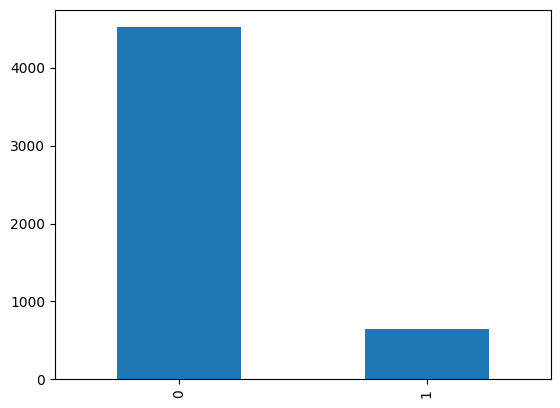

In [10]:
data['v1'].value_counts().plot(kind='bar')
plt.show()

<br>

- 레이블이 대부분 0에 편중
  이는 스팸 메일 데이터의 대부분의 메일이 정상 메일임을 의미

In [12]:
print('정상 메일과 스팸 메일의 개수')
data.groupby('v1').size().reset_index(name='count')

정상 메일과 스팸 메일의 개수


,v1,count
0,0,4516
1,1,653


In [13]:
print(f'정상 메일의 비율 = {round(data["v1"].value_counts()[0]/len(data) * 100,3)}%')
print(f'스팸 메일의 비율 = {round(data["v1"].value_counts()[1]/len(data) * 100,3)}%')

정상 메일의 비율 = 87.367%
스팸 메일의 비율 = 12.633%


<br>

- v2열과 v1열을 X데이터와 y데이터라는 X_data, y_data로 저장


In [14]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


<br>

#### 훈련 데이터와 테스트 데이터를 분리
* **현재 레이블이 굉장히 불균형 $→$ `train_test_split`에 `stratify`의 인자로서 레이블 데이터를 기재**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [16]:
print('--------훈련 데이터의 비율-----------')
print(f'정상 메일 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'스팸 메일 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
정상 메일 = 87.376%
스팸 메일 = 12.624%


<br>

#### 데이터에 대해서 토큰화와 정수 인코딩

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)

In [20]:
word_to_index = tokenizer.word_index

<br>

#### `토크나이저객체.word_counts.items()` : 각 단어에 대한 등장 빈도수 확인

In [21]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [22]:
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [23]:
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4337
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.45326684567191
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.65745644331875


<br>

- **등장 빈도가 1회인 단어들을 제외**

```python
tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)
``` ``

In [25]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 7822


<br>

- 전체 데이터에서 가장 길이가 긴 메일과 전체 메일 데이터의 길이 분포를 확인

메일의 최대 길이 : 189
메일의 평균 길이 : 15.754534


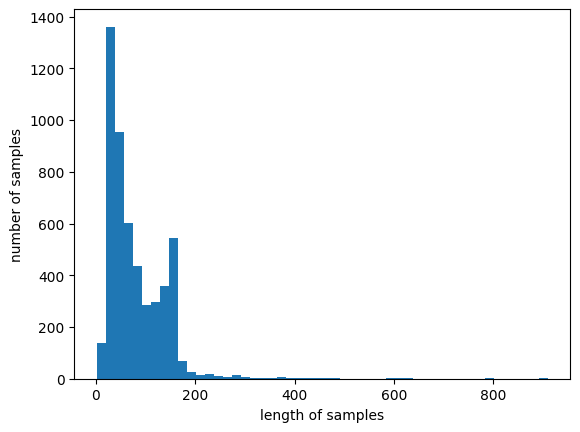

In [26]:
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_train_encoded)))

plt.hist([len(sample) for sample in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
plt.show()

<br>

- **가장 긴 메일의 길이로 패딩**

In [27]:
max_len = 189
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (4135, 189)


<br>

#### 분류 모델 생성

In [28]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [29]:
embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          250304    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 252,417
Trainable params: 252,417
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [32]:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=False)

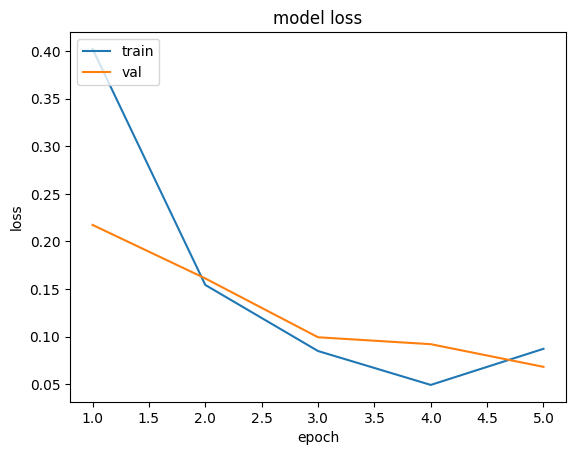

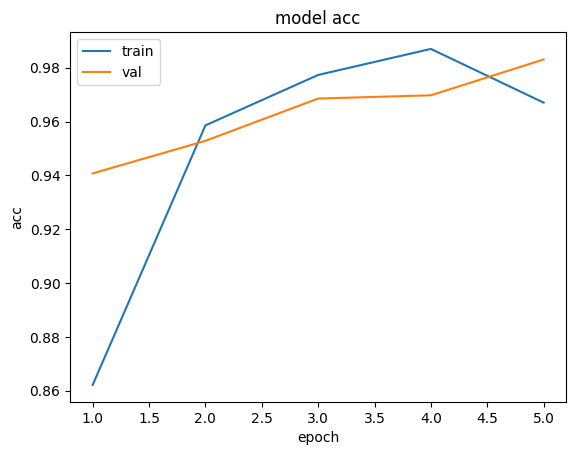

In [42]:
epochs = range(1, len(history.history['acc']) + 1)

plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<br>

#### 모델 평가

In [33]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

33/33 [==============================] - 0s 6ms/step - loss: 0.0632 - acc: 0.9826

 테스트 정확도: 0.9826


<br>

<br>

## 로이터 뉴스 분류 (Reuters News Classification)

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

<br>

#### 데이터 로드 전처리

In [44]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

2110848/2110848 [==============================] - 0s 0us/step
훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


<br>

#### 데이터 분포 확인

뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


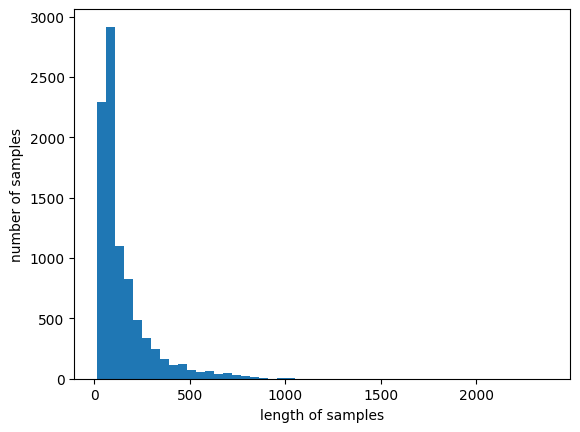

In [49]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(sample) for sample in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(sample) for sample in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

<br>

- 각 뉴스의 레이블 값의 분포

In [62]:
ique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [79]:
word_to_index = reuters.get_word_index()

index_to_word = {}

for key, value in word_to_index.items():
    index_to_word[value+3] = key

In [80]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[4]))

빈도수 상위 1번 단어 : the


In [81]:
print('빈도수 상위 128등 단어 : {}'.format(index_to_word[131]))

빈도수 상위 128등 단어 : tax


<br>

### LSTM 분류 모델 생성

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

<br>

- 훈련/테스트 데이터 생성
- 패딩
- 원-핫 인코딩

In [72]:
vocab_size = 1000
max_len = 100

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

<br>

#### 모델 구축

In [73]:
embedding_dim = 128
hidden_units = 128
num_classes = 46

In [74]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         128000    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 46)                5934      
                                                                 
Total params: 265,518
Trainable params: 265,518
Non-trainable params: 0
_________________________________________________________________


In [77]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=False, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [78]:
history = model.fit(X_train, y_train, 
                    batch_size=128, epochs=30, 
                    callbacks=[es, mc], validation_data=(X_test, y_test),
                    verbose=False)

Epoch 17: early stopping


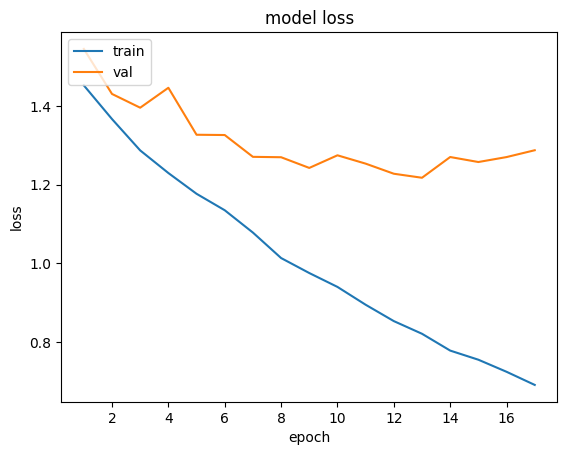

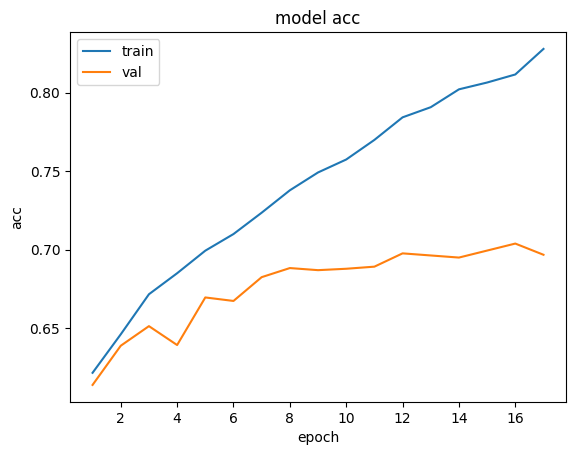

In [82]:
epochs = range(1, len(history.history['acc']) + 1)

plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<br>

#### 모델 평가

In [83]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 3s 35ms/step - loss: 1.2698 - acc: 0.7039

 테스트 정확도: 0.7039


<br>

<br>

## IMDB 리뷰 감성 분류 (IMDB Movie Review Sentiment Analysis)



In [84]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb

<br>

#### 데이터 로드 전처리

In [85]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

17464789/17464789 [==============================] - 0s 0us/step
훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


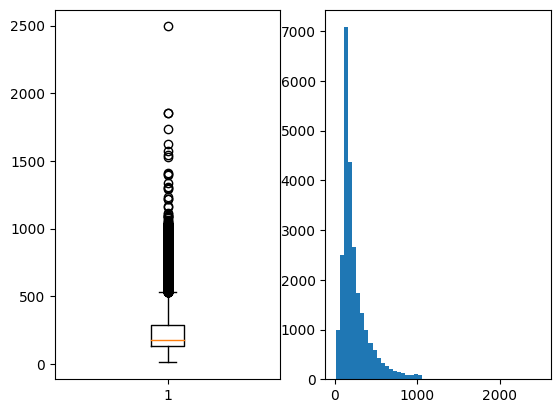

In [86]:
reviews_length = [len(review) for review in X_train]

print('리뷰의 최대 길이 : {}'.format(np.max(reviews_length)))
print('리뷰의 평균 길이 : {}'.format(np.mean(reviews_length)))

plt.subplot(1,2,1)
plt.boxplot(reviews_length)
plt.subplot(1,2,2)
plt.hist(reviews_length, bins=50)
plt.show()

In [87]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[    0     1]
 [12500 12500]]


In [88]:
word_to_index = imdb.get_word_index()
index_to_word = {}

for key, value in word_to_index.items():
    index_to_word[value+3] = key

1641221/1641221 [==============================] - 0s 0us/step


In [89]:
print('빈도수 상위 1등 단어 : {}'.format(index_to_word[4]))
print('빈도수 상위 3938등 단어 : {}'.format(index_to_word[3941]))

빈도수 상위 1등 단어 : the
빈도수 상위 3938등 단어 : suited


<br>

<br>

### GRU 분류 모델 생성

In [90]:
import re
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

<br>

- 훈련/테스트 데이터 생성
- 패딩

In [92]:
vocab_size = 10000
max_len = 500

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

<br>

### 모델 구축

In [94]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         1000000   
                                                                 
 gru_1 (GRU)                 (None, 128)               88320     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,088,449
Trainable params: 1,088,449
Non-trainable params: 0
_________________________________________________________________


In [96]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=False, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [98]:
history = model.fit(X_train, y_train,
                    epochs=15, callbacks=[es, mc], 
                    batch_size=64, validation_split=0.2, verbose=False)

Epoch 10: early stopping


<br> 

#### 모델 평가

In [99]:
loaded_model = load_model('GRU_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 56s 71ms/step - loss: 0.4253 - acc: 0.8732

 테스트 정확도: 0.8732


<br>

#### 임의의 문장에 대해서 리뷰의 긍, 부정을 예측

In [100]:
def sentiment_predict(new_sentence):

  # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()
  encoded = []

  # 띄어쓰기 단위 토큰화 후 정수 인코딩
  for word in new_sentence.split():
    try :
      # 단어 집합의 크기를 10,000으로 제한.
      if word_to_index[word] <= 10000:
        encoded.append(word_to_index[word]+3)
      else:
      # 10,000 이상의 숫자는 <unk> 토큰으로 변환.
        encoded.append(2)
        
    # 단어 집합에 없는 단어는 <unk> 토큰으로 변환.
    except KeyError:
      encoded.append(2)

  pad_sequence = pad_sequences([encoded], maxlen=max_len)
  score = float(loaded_model.predict(pad_sequence)) # 예측

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [101]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(test_input)

1/1 [==============================] - 0s 289ms/step
78.63% 확률로 부정 리뷰입니다.


In [102]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. \
Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. \
Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

sentiment_predict(test_input)

1/1 [==============================] - 0s 31ms/step
99.79% 확률로 긍정 리뷰입니다.


<br>

<br>

## 나이브 베이즈 분류기(Naive Bayes Classifier)

<br>

### 베이즈의 정리(Bayes' theorem)를 이용한 분류 메커니즘
- $P(A)$ : A가 일어날 확률, 
- $P(B)$ : B가 일어날 확률, 
- $P(B|A)$ : A가 일어나고나서 B가 일어날 확률, 
- $P(A|B)$ : B가 일어나고나서 A가 일어날 확률

$$P(A|B)=\frac{P(B|A)P(A)}{P(B)}$$

<br>

- 입력 텍스트(메일의 본문)이 주어졌을 때, 입력 텍스트가 정상 메일인지 스팸 메일인지 구분하기 위한 확률 

    ```
    P(정상 메일 | 입력 텍스트) = 입력 텍스트가 있을 때 정상 메일일 확률

    P(스팸 메일 | 입력 텍스트) = 입력 텍스트가 있을 때 스팸 메일일 확률
    ```

    <br>
    - 베이즈의 정리에 따라서 식을 표현

    ```
    P(정상 메일 | 입력 텍스트) = (P(입력 텍스트 | 정상 메일) × P(정상 메일)) / P(입력 텍스트)

    P(스팸 메일 | 입력 텍스트) = (P(입력 텍스트 | 스팸 메일) × P(스팸 메일)) / P(입력 텍스트)
    ```

- 입력 텍스트가 주어졌을 때, **```P(정상 메일 | 입력 텍스트)```가 ```P(스팸 메일 | 입력 텍스트)```보다 크다면 정상 메일이라고 볼 수 있으며, 그 반대라면 스팸 메일이라고 볼 수 있음**
  - **두 확률의 비교에 있어 식을 간소화**

    ```
    P(정상 메일 | 입력 텍스트) = P(입력 텍스트 | 정상 메일) × P(정상 메일)

    P(스팸 메일 | 입력 텍스트) = P(입력 텍스트 | 스팸 메일) × P(스팸 메일)

    ```

<br>

- **메일의 본문을 단어 토큰화하여 이 단어들을 나이브 베이즈의 분류기의 입력으로 사용**
- **나이브 베이즈 분류기는 모든 단어가 독립적이라고 가정**
- 메일의 본문에 있는 단어 3개를 $w_1$, $w_2$, $w_3$라고 표현한다면 결국 나이브 베이즈 분류기의 정상 메일일 확률과 스팸 메일일 확률을 구하는 식

    ```
    P(정상 메일 | 입력 텍스트) = P(w1 | 정상 메일) × P(w2 | 정상 메일) × P(w3 | 정상 메일) × P(정상 메일)

    P(스팸 메일 | 입력 텍스트) = P(w1 | 스팸 메일) × P(w2 | 스팸 메일) × P(w3 | 스팸 메일) × P(스팸 메일)
    ```
<br>

**나이브 베이즈 분류기에서 토큰화 이전의 단어의 순서는 중요하지 않음**

**즉, BoW와 같이 단어의 순서를 무시하고 오직 빈도수만을 고려**

<br>

### 데이터 로드

In [103]:
from sklearn.datasets import fetch_20newsgroups
newsdata=fetch_20newsgroups(subset='train')
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [105]:
print (len(newsdata.data), len(newsdata.filenames), len(newsdata.target_names), len(newsdata.target))

11314 11314 20 11314


<br>

- 뉴스 카테고리

In [108]:
newsdata.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

<br>

### 나이브 베이즈 분류 모델 생성

- **나이브 베이즈 분류를 위해서는 데이터를 BoW로**

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

<br>

- DTM생성
  - **11,314는 훈련용 샘플의 개수 $→$ DTM 관점에서는 문서의 수**
  - **130,107은 전체 훈련 데이터에 등장한 단어의 수**

In [110]:
dtmvector = CountVectorizer()
X_train_dtm = dtmvector.fit_transform(newsdata.data)

print(X_train_dtm.shape)

(11314, 130107)


<br>

-  DTM 행렬 대신 TF-IDF 가중치를 적용한 TF-IDF 행렬을 입력으로 텍스트 분류를 수행하면, 성능의 개선을 얻을 수도 있음
  - TF-IDF 행렬이 항상 DTM으로 수행했을 때보다 성능이 뛰어나지는 않음
 

In [111]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(X_train_dtm)
print(tfidfv.shape)

(11314, 130107)


<br>

- 모델 구축 & 적합

In [112]:
mod = MultinomialNB()
mod.fit(tfidfv, newsdata.target)

MultinomialNB()

- `alpha=1.0` : 라플라스 스무딩

In [113]:
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB()

<br>

- 모델 평가

In [114]:
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True) 

X_test_dtm = dtmvector.transform(newsdata_test.data) 
tfidfv_test = tfidf_transformer.transform(X_test_dtm)

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(newsdata_test.target, predicted))

정확도: 0.7738980350504514
